In [1]:
import os
# import pkg_resources
# pkg_resources.require('Torch==2.0.1')
!pip install torch==2.0.1
import torch
print('Using torch', torch.__version__)
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install ogb
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [21]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.utils import degree
from torch_geometric.utils import to_dense_batch

from ogb.graphproppred.mol_encoder import BondEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, global_add_pool as gsp

from torch_geometric.utils import to_dense_batch

# from models.layers import SAB, ISAB, PMA
# from models.layers import GCNConv_for_OGB, GINConv_for_OGB

from ogb.graphproppred.mol_encoder import AtomEncoder

from math import ceil

# set seed
seed_value = 108
torch.manual_seed(seed_value)

class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False, cluster=False, conv=None):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)

        self.fc_k, self.fc_v = self.get_fc_kv(dim_K, dim_V, conv)

        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

        self.softmax_dim = 2
        if cluster == True:
            self.softmax_dim = 1

    def forward(self, Q, K, attention_mask=None, graph=None, return_attn=False):
        Q = self.fc_q(Q)

        # Adj: Exist (graph is not None), or Identity (else)
        if graph is not None:

            (x, edge_index, batch) = graph

            K, V = self.fc_k(x, edge_index), self.fc_v(x, edge_index)

            K, _ = to_dense_batch(K, batch)
            V, _ = to_dense_batch(V, batch)

        else:

            K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        if attention_mask is not None:
            attention_mask = torch.cat([attention_mask for _ in range(self.num_heads)], 0)
            attention_score = Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V)
            A = torch.softmax(attention_mask + attention_score, self.softmax_dim)
        else:
            A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), self.softmax_dim)

        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        if return_attn:
            return O, A
        else:
            return O

    def get_fc_kv(self, dim_K, dim_V, conv):

        if conv == 'GCN':

            fc_k = GCNConv(dim_K, dim_V)
            fc_v = GCNConv(dim_K, dim_V)

        elif conv == 'GIN':

            fc_k = GINConv(
                nn.Sequential(
                    nn.Linear(dim_K, dim_K),
                    nn.ReLU(),
                    nn.Linear(dim_K, dim_V),
                    nn.ReLU(),
                    nn.BatchNorm1d(dim_V),
            ), train_eps=False)

            fc_v = GINConv(
                nn.Sequential(
                    nn.Linear(dim_K, dim_K),
                    nn.ReLU(),
                    nn.Linear(dim_K, dim_V),
                    nn.ReLU(),
                    nn.BatchNorm1d(dim_V),
            ), train_eps=False)

        else:

            fc_k = nn.Linear(dim_K, dim_V)
            fc_v = nn.Linear(dim_K, dim_V)

        return fc_k, fc_v

class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False, cluster=False, mab_conv=None):
        super(SAB, self).__init__()

        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln, cluster=cluster, conv=mab_conv)

    def forward(self, X, attention_mask=None, graph=None):
        return self.mab(X, X, attention_mask, graph)

class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False, cluster=False, mab_conv=None):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)

        self.mab0 = MAB(dim_out, dim_in, dim_out, num_heads, ln=ln, cluster=cluster, conv=mab_conv)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln, cluster=cluster, conv=mab_conv)

    def forward(self, X, attention_mask=None, graph=None):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X, attention_mask, graph)
        return self.mab1(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False, cluster=False, mab_conv=None):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)

        self.mab = MAB(dim, dim, dim, num_heads, ln=ln, cluster=cluster, conv=mab_conv)

    def forward(self, X, attention_mask=None, graph=None, return_attn=False):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X, attention_mask, graph, return_attn)

### GCN convolution along the graph structure
class GCNConv_for_OGB(MessagePassing):
    def __init__(self, emb_dim):
        super(GCNConv_for_OGB, self).__init__(aggr='add')

        self.linear = torch.nn.Linear(emb_dim, emb_dim)
        self.root_emb = torch.nn.Embedding(1, emb_dim)
        self.bond_encoder = BondEncoder(emb_dim = emb_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.linear(x)
        edge_embedding = self.bond_encoder(edge_attr)

        row, col = edge_index

        deg = degree(row, x.size(0), dtype = x.dtype) + 1
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return self.propagate(edge_index, x=x, edge_attr=edge_embedding, norm=norm) + F.relu(x + self.root_emb.weight) * 1./deg.view(-1,1)

    def message(self, x_j, edge_attr, norm):
        return norm.view(-1, 1) * F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

### GIN convolution along the graph structure
class GINConv_for_OGB(MessagePassing):
    def __init__(self, emb_dim):
        super(GINConv_for_OGB, self).__init__(aggr = "add")

        self.mlp = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2*emb_dim), torch.nn.BatchNorm1d(2*emb_dim), torch.nn.ReLU(), torch.nn.Linear(2*emb_dim, emb_dim))
        self.eps = torch.nn.Parameter(torch.Tensor([0]))

        self.bond_encoder = BondEncoder(emb_dim = emb_dim)

    def forward(self, x, edge_index, edge_attr):
        edge_embedding = self.bond_encoder(edge_attr)
        out = self.mlp((1 + self.eps) * x + self.propagate(edge_index, x=x, edge_attr=edge_embedding))

        return out

    def message(self, x_j, edge_attr):
        return F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

In [3]:
class GraphRepresentation(torch.nn.Module):

    def __init__(self, args):

        super(GraphRepresentation, self).__init__()

        self.args = args
        self.num_features = args.num_features
        self.nhid = args.num_hidden
        self.num_classes = args.num_classes
        self.pooling_ratio = args.pooling_ratio
        self.dropout_ratio = args.dropout

    def get_convs(self):

        convs = nn.ModuleList()

        _input_dim = self.num_features
        _output_dim = self.nhid

        for _ in range(self.args.num_convs):

            if self.args.conv == 'GCN':

                conv = GCNConv(_input_dim, _output_dim)

            elif self.args.conv == 'GIN':

                conv = GINConv(
                    nn.Sequential(
                        nn.Linear(_input_dim, _output_dim),
                        nn.ReLU(),
                        nn.Linear(_output_dim, _output_dim),
                        nn.ReLU(),
                        nn.BatchNorm1d(_output_dim),
                ), train_eps=False)

            convs.append(conv)

            _input_dim = _output_dim
            _output_dim = _output_dim

        return convs

    def get_pools(self):

        pools = nn.ModuleList([gap])

        return pools

    def get_classifier(self):

        return nn.Sequential(
            nn.Linear(self.nhid, self.nhid),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(self.nhid, self.nhid//2),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(self.nhid//2, self.num_classes)
        )

class GraphMultisetTransformer(GraphRepresentation):

    def __init__(self, args):

        super(GraphMultisetTransformer, self).__init__(args)

        self.ln = args.ln
        self.num_heads = args.num_heads
        self.cluster = args.cluster

        self.model_sequence = args.model_string.split('-')

        self.convs = self.get_convs()
        self.pools = self.get_pools()
        self.classifier = self.get_classifier()

    def forward(self, data):

        x, edge_index, batch = data.x, data.edge_index, data.batch

        # For Graph Convolution Network
        xs = []

        for _ in range(self.args.num_convs):

            x = F.relu(self.convs[_](x, edge_index))
            xs.append(x)

        # For jumping knowledge scheme
        x = torch.cat(xs, dim=1)

        # For Graph Multiset Transformer
        for _index, _model_str in enumerate(self.model_sequence):

            if _index == 0:

                batch_x, mask = to_dense_batch(x, batch)

                extended_attention_mask = mask.unsqueeze(1)
                extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
                extended_attention_mask = (1.0 - extended_attention_mask) * -1e9

            if _model_str == 'GMPool_G':

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask, graph=(x, edge_index, batch))

            else:

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask)

            extended_attention_mask = None

        batch_x = self.pools[len(self.model_sequence)](batch_x)
        x = batch_x.squeeze(1)

        # For Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=-1)

    def get_pools(self, _input_dim=None, reconstruction=False):

        pools = nn.ModuleList()

        _input_dim = self.nhid * self.args.num_convs if _input_dim is None else _input_dim
        _output_dim = self.nhid
        _num_nodes = ceil(self.pooling_ratio * self.args.avg_num_nodes)

        for _index, _model_str in enumerate(self.model_sequence):

            if (_index == len(self.model_sequence) - 1) and (reconstruction == False):

                _num_nodes = 1

            if _model_str == 'GMPool_G':

                pools.append(
                    PMA(_input_dim, self.num_heads, _num_nodes, ln=self.ln, cluster=self.cluster, mab_conv=self.args.mab_conv)
                )

                _num_nodes = ceil(self.pooling_ratio * _num_nodes)

            elif _model_str == 'GMPool_I':

                pools.append(
                    PMA(_input_dim, self.num_heads, _num_nodes, ln=self.ln, cluster=self.cluster, mab_conv=None)
                )

                _num_nodes = ceil(self.pooling_ratio * _num_nodes)

            elif _model_str == 'SelfAtt':

                pools.append(
                    SAB(_input_dim, _output_dim, self.num_heads, ln=self.ln, cluster=self.cluster)
                )

                _input_dim = _output_dim
                _output_dim = _output_dim

            else:

                raise ValueError("Model Name in Model String <{}> is Unknown".format(_model_str))

        pools.append(nn.Linear(_input_dim, self.nhid))

        return pools

class GraphMultisetTransformer_for_OGB(GraphMultisetTransformer):

    def __init__(self, args):

        super(GraphMultisetTransformer_for_OGB, self).__init__(args)

        self.atom_encoder = AtomEncoder(self.nhid)
        self.convs = self.get_convs()

    def forward(self, data):

        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.atom_encoder(x)

        # For Graph Convolution Network
        xs = []

        for _ in range(self.args.num_convs):

            x = F.relu(self.convs[_](x, edge_index, edge_attr))
            xs.append(x)

        # For jumping knowledge scheme
        x = torch.cat(xs, dim=1)

        # For Graph Multiset Transformer
        for _index, _model_str in enumerate(self.model_sequence):

            if _index == 0:

                batch_x, mask = to_dense_batch(x, batch)

                extended_attention_mask = mask.unsqueeze(1)
                extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
                extended_attention_mask = (1.0 - extended_attention_mask) * -1e9

            if _model_str == 'GMPool_G':

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask, graph=(x, edge_index, batch))

            else:

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask)

            extended_attention_mask = None

        batch_x = self.pools[len(self.model_sequence)](batch_x)
        x = batch_x.squeeze(1)

        # For Classification
        x = self.classifier(x)

        return x

    def get_convs(self):

        convs = nn.ModuleList()

        for _ in range(self.args.num_convs):

            if self.args.conv == 'GCN':

                conv = GCNConv_for_OGB(self.nhid)

            elif self.args.conv == 'GIN':

                conv = GINConv_for_OGB(self.nhid)

            convs.append(conv)

        return convs

In [6]:
import matplotlib.pyplot as plt

def plot_training_metrics(losses, val_metrics, test_metrics, epoch_times):
    """
    Plot training loss, validation metric, and test metric over epochs.

    Parameters:
    - losses: List of training losses for each epoch.
    - val_metrics: List of validation metrics for each epoch.
    - test_metrics: List of test metrics for each epoch.
    """
    epochs = range(1, len(losses) + 1)

    # Plotting training loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, losses, label='Training Loss', marker='o')
    plt.title('Training Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting validation and test metrics
    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_metrics, label='Validation Metric', marker='o')
    plt.plot(epochs, test_metrics, label='Test Metric', marker='o')
    plt.title('Validation and Test Metrics vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()

    # Plotting time vs. epoch
    plt.subplot(1, 3, 3)
    plt.plot(epochs, epoch_times, label='Time per Epoch', marker='o', color='orange')
    plt.title('Epoch Time vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Time (seconds)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_training_metrics(training_losses, validation_metrics, test_metrics)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.74it/s]


Epoch: 001, Loss: 0.7089, Val Acc: 0.3304, Test Acc: 0.3964


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.26it/s]


Epoch: 002, Loss: 0.6977, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.45it/s]


Epoch: 003, Loss: 0.6901, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.24it/s]


Epoch: 004, Loss: 0.6858, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.99it/s]


Epoch: 005, Loss: 0.6839, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.13it/s]


Epoch: 006, Loss: 0.6825, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.83it/s]


Epoch: 007, Loss: 0.6816, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.95it/s]


Epoch: 008, Loss: 0.6807, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.32it/s]


Epoch: 009, Loss: 0.6798, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.05it/s]


Epoch: 010, Loss: 0.6790, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.93it/s]


Epoch: 011, Loss: 0.6783, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.79it/s]


Epoch: 012, Loss: 0.6776, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.58it/s]


Epoch: 013, Loss: 0.6771, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.74it/s]


Epoch: 014, Loss: 0.6762, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.44it/s]


Epoch: 015, Loss: 0.6756, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.17it/s]


Epoch: 016, Loss: 0.6749, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.10it/s]


Epoch: 017, Loss: 0.6742, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.10it/s]


Epoch: 018, Loss: 0.6736, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.89it/s]


Epoch: 019, Loss: 0.6730, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.89it/s]


Epoch: 020, Loss: 0.6723, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.90it/s]


Epoch: 021, Loss: 0.6717, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.29it/s]


Epoch: 022, Loss: 0.6711, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.69it/s]


Epoch: 023, Loss: 0.6705, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.10it/s]


Epoch: 024, Loss: 0.6699, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.18it/s]


Epoch: 025, Loss: 0.6692, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Epoch: 026, Loss: 0.6688, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.48it/s]


Epoch: 027, Loss: 0.6680, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.76it/s]


Epoch: 028, Loss: 0.6675, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.97it/s]


Epoch: 029, Loss: 0.6670, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.16it/s]


Epoch: 030, Loss: 0.6664, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.52it/s]


Epoch: 031, Loss: 0.6657, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.93it/s]


Epoch: 032, Loss: 0.6652, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.00it/s]


Epoch: 033, Loss: 0.6647, Val Acc: 0.6696, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.28it/s]


Epoch: 034, Loss: 0.6642, Val Acc: 0.6964, Test Acc: 0.6126


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.85it/s]


Epoch: 035, Loss: 0.6634, Val Acc: 0.6964, Test Acc: 0.6126


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Epoch: 036, Loss: 0.6629, Val Acc: 0.6964, Test Acc: 0.6126


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.63it/s]


Epoch: 037, Loss: 0.6624, Val Acc: 0.6964, Test Acc: 0.6126


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.89it/s]


Epoch: 038, Loss: 0.6618, Val Acc: 0.6964, Test Acc: 0.6126


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.45it/s]


Epoch: 039, Loss: 0.6613, Val Acc: 0.6964, Test Acc: 0.6126


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.69it/s]


Epoch: 040, Loss: 0.6606, Val Acc: 0.6964, Test Acc: 0.6126


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.58it/s]


Epoch: 041, Loss: 0.6601, Val Acc: 0.6964, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.59it/s]


Epoch: 042, Loss: 0.6596, Val Acc: 0.6875, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.57it/s]


Epoch: 043, Loss: 0.6592, Val Acc: 0.6964, Test Acc: 0.6126


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.41it/s]


Epoch: 044, Loss: 0.6585, Val Acc: 0.6875, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.44it/s]


Epoch: 045, Loss: 0.6581, Val Acc: 0.6875, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.84it/s]


Epoch: 046, Loss: 0.6573, Val Acc: 0.6875, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.16it/s]


Epoch: 047, Loss: 0.6569, Val Acc: 0.6964, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.22it/s]


Epoch: 048, Loss: 0.6564, Val Acc: 0.6875, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.35it/s]


Epoch: 049, Loss: 0.6559, Val Acc: 0.6964, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.76it/s]


Epoch: 050, Loss: 0.6553, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.47it/s]


Epoch: 051, Loss: 0.6549, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.78it/s]


Epoch: 052, Loss: 0.6545, Val Acc: 0.6964, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.00it/s]


Epoch: 053, Loss: 0.6541, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.62it/s]


Epoch: 054, Loss: 0.6533, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.33it/s]


Epoch: 055, Loss: 0.6527, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.59it/s]


Epoch: 056, Loss: 0.6522, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.35it/s]


Epoch: 057, Loss: 0.6517, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.42it/s]


Epoch: 058, Loss: 0.6512, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.16it/s]


Epoch: 059, Loss: 0.6508, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.79it/s]


Epoch: 060, Loss: 0.6502, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.05it/s]


Epoch: 061, Loss: 0.6497, Val Acc: 0.7143, Test Acc: 0.6126


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.09it/s]


Epoch: 062, Loss: 0.6491, Val Acc: 0.7143, Test Acc: 0.6126


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.45it/s]


Epoch: 063, Loss: 0.6487, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.68it/s]


Epoch: 064, Loss: 0.6481, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.90it/s]


Epoch: 065, Loss: 0.6474, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.52it/s]


Epoch: 066, Loss: 0.6471, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.19it/s]


Epoch: 067, Loss: 0.6463, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.02it/s]


Epoch: 068, Loss: 0.6458, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.16it/s]


Epoch: 069, Loss: 0.6453, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.41it/s]


Epoch: 070, Loss: 0.6446, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.31it/s]


Epoch: 071, Loss: 0.6442, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.22it/s]


Epoch: 072, Loss: 0.6437, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.15it/s]


Epoch: 073, Loss: 0.6432, Val Acc: 0.7143, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.57it/s]


Epoch: 074, Loss: 0.6428, Val Acc: 0.7143, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.75it/s]


Epoch: 075, Loss: 0.6420, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.19it/s]


Epoch: 076, Loss: 0.6416, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.00it/s]


Epoch: 077, Loss: 0.6409, Val Acc: 0.7232, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.47it/s]


Epoch: 078, Loss: 0.6404, Val Acc: 0.7232, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.77it/s]


Epoch: 079, Loss: 0.6402, Val Acc: 0.7054, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.78it/s]


Epoch: 080, Loss: 0.6400, Val Acc: 0.7232, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.53it/s]


Epoch: 081, Loss: 0.6391, Val Acc: 0.7232, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.75it/s]


Epoch: 082, Loss: 0.6384, Val Acc: 0.7232, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.69it/s]


Epoch: 083, Loss: 0.6379, Val Acc: 0.7232, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.96it/s]


Epoch: 084, Loss: 0.6375, Val Acc: 0.7232, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.90it/s]


Epoch: 085, Loss: 0.6372, Val Acc: 0.7232, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.31it/s]


Epoch: 086, Loss: 0.6366, Val Acc: 0.7232, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.61it/s]


Epoch: 087, Loss: 0.6361, Val Acc: 0.7232, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.64it/s]


Epoch: 088, Loss: 0.6358, Val Acc: 0.7232, Test Acc: 0.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.80it/s]


Epoch: 089, Loss: 0.6351, Val Acc: 0.7232, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.96it/s]


Epoch: 090, Loss: 0.6348, Val Acc: 0.7232, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.81it/s]


Epoch: 091, Loss: 0.6343, Val Acc: 0.7232, Test Acc: 0.5946


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.36it/s]


Epoch: 092, Loss: 0.6342, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.98it/s]


Epoch: 093, Loss: 0.6334, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.28it/s]


Epoch: 094, Loss: 0.6330, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.08it/s]


Epoch: 095, Loss: 0.6328, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.77it/s]


Epoch: 096, Loss: 0.6324, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.99it/s]


Epoch: 097, Loss: 0.6318, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.41it/s]


Epoch: 098, Loss: 0.6315, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.81it/s]


Epoch: 099, Loss: 0.6309, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.55it/s]


Epoch: 100, Loss: 0.6308, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.31it/s]


Epoch: 101, Loss: 0.6302, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.62it/s]


Epoch: 102, Loss: 0.6302, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.69it/s]


Epoch: 103, Loss: 0.6295, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.97it/s]


Epoch: 104, Loss: 0.6291, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.24it/s]


Epoch: 105, Loss: 0.6287, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.00it/s]


Epoch: 106, Loss: 0.6283, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.35it/s]


Epoch: 107, Loss: 0.6281, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.16it/s]


Epoch: 108, Loss: 0.6279, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.03it/s]


Epoch: 109, Loss: 0.6277, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.40it/s]


Epoch: 110, Loss: 0.6274, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.24it/s]


Epoch: 111, Loss: 0.6269, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.15it/s]


Epoch: 112, Loss: 0.6274, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.87it/s]


Epoch: 113, Loss: 0.6264, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.74it/s]


Epoch: 114, Loss: 0.6260, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.17it/s]


Epoch: 115, Loss: 0.6257, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.76it/s]


Epoch: 116, Loss: 0.6255, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.78it/s]


Epoch: 117, Loss: 0.6255, Val Acc: 0.7589, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.87it/s]


Epoch: 118, Loss: 0.6251, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Epoch: 119, Loss: 0.6247, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.54it/s]


Epoch: 120, Loss: 0.6245, Val Acc: 0.7589, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.69it/s]


Epoch: 121, Loss: 0.6243, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Epoch: 122, Loss: 0.6243, Val Acc: 0.7679, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.76it/s]


Epoch: 123, Loss: 0.6237, Val Acc: 0.7589, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.68it/s]


Epoch: 124, Loss: 0.6235, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.78it/s]


Epoch: 125, Loss: 0.6235, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.49it/s]


Epoch: 126, Loss: 0.6231, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Epoch: 127, Loss: 0.6229, Val Acc: 0.7679, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.80it/s]


Epoch: 128, Loss: 0.6227, Val Acc: 0.7679, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.62it/s]


Epoch: 129, Loss: 0.6225, Val Acc: 0.7589, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.64it/s]


Epoch: 130, Loss: 0.6223, Val Acc: 0.7589, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.80it/s]


Epoch: 131, Loss: 0.6226, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.21it/s]


Epoch: 132, Loss: 0.6220, Val Acc: 0.7589, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.84it/s]


Epoch: 133, Loss: 0.6221, Val Acc: 0.7768, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.79it/s]


Epoch: 134, Loss: 0.6216, Val Acc: 0.7768, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.49it/s]


Epoch: 135, Loss: 0.6215, Val Acc: 0.7768, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.32it/s]


Epoch: 136, Loss: 0.6211, Val Acc: 0.7589, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.57it/s]


Epoch: 137, Loss: 0.6213, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.27it/s]


Epoch: 138, Loss: 0.6208, Val Acc: 0.7589, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.59it/s]


Epoch: 139, Loss: 0.6208, Val Acc: 0.7768, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.43it/s]


Epoch: 140, Loss: 0.6206, Val Acc: 0.7768, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.68it/s]


Epoch: 141, Loss: 0.6203, Val Acc: 0.7768, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.02it/s]


Epoch: 142, Loss: 0.6200, Val Acc: 0.7768, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.89it/s]


Epoch: 143, Loss: 0.6199, Val Acc: 0.7589, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.12it/s]


Epoch: 144, Loss: 0.6199, Val Acc: 0.7679, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.51it/s]


Epoch: 145, Loss: 0.6197, Val Acc: 0.7589, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.21it/s]


Epoch: 146, Loss: 0.6195, Val Acc: 0.7768, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.57it/s]


Epoch: 147, Loss: 0.6195, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.08it/s]


Epoch: 148, Loss: 0.6192, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.38it/s]


Epoch: 149, Loss: 0.6191, Val Acc: 0.7589, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.83it/s]


Epoch: 150, Loss: 0.6189, Val Acc: 0.7589, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.12it/s]


Epoch: 151, Loss: 0.6189, Val Acc: 0.7679, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.86it/s]


Epoch: 152, Loss: 0.6185, Val Acc: 0.7679, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.35it/s]


Epoch: 153, Loss: 0.6184, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.69it/s]


Epoch: 154, Loss: 0.6185, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.35it/s]


Epoch: 155, Loss: 0.6181, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.55it/s]


Epoch: 156, Loss: 0.6179, Val Acc: 0.7768, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.90it/s]


Epoch: 157, Loss: 0.6179, Val Acc: 0.7679, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.63it/s]


Epoch: 158, Loss: 0.6178, Val Acc: 0.7768, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.64it/s]


Epoch: 159, Loss: 0.6180, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.16it/s]


Epoch: 160, Loss: 0.6176, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.82it/s]


Epoch: 161, Loss: 0.6176, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.24it/s]


Epoch: 162, Loss: 0.6173, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.90it/s]


Epoch: 163, Loss: 0.6177, Val Acc: 0.7679, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.94it/s]


Epoch: 164, Loss: 0.6171, Val Acc: 0.7679, Test Acc: 0.6216


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.33it/s]


Epoch: 165, Loss: 0.6170, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.74it/s]


Epoch: 166, Loss: 0.6170, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.91it/s]


Epoch: 167, Loss: 0.6169, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Epoch: 168, Loss: 0.6168, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.08it/s]


Epoch: 169, Loss: 0.6167, Val Acc: 0.7679, Test Acc: 0.6306


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.17it/s]


Epoch: 170, Loss: 0.6167, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.11it/s]


Epoch: 171, Loss: 0.6164, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.54it/s]


Epoch: 172, Loss: 0.6164, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Epoch: 173, Loss: 0.6164, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.99it/s]


Epoch: 174, Loss: 0.6161, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.89it/s]


Epoch: 175, Loss: 0.6160, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.00it/s]


Epoch: 176, Loss: 0.6164, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.12it/s]


Epoch: 177, Loss: 0.6161, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.73it/s]


Epoch: 178, Loss: 0.6158, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.47it/s]


Epoch: 179, Loss: 0.6158, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.63it/s]


Epoch: 180, Loss: 0.6161, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.50it/s]


Epoch: 181, Loss: 0.6159, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.61it/s]


Epoch: 182, Loss: 0.6157, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.17it/s]


Epoch: 183, Loss: 0.6155, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Epoch: 184, Loss: 0.6154, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.02it/s]


Epoch: 185, Loss: 0.6154, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.99it/s]


Epoch: 186, Loss: 0.6152, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.26it/s]


Epoch: 187, Loss: 0.6154, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.86it/s]


Epoch: 188, Loss: 0.6152, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.72it/s]


Epoch: 189, Loss: 0.6151, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.79it/s]


Epoch: 190, Loss: 0.6150, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.68it/s]


Epoch: 191, Loss: 0.6151, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.76it/s]


Epoch: 192, Loss: 0.6152, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.99it/s]


Epoch: 193, Loss: 0.6149, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.62it/s]


Epoch: 194, Loss: 0.6148, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.56it/s]


Epoch: 195, Loss: 0.6150, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.71it/s]


Epoch: 196, Loss: 0.6147, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.70it/s]


Epoch: 197, Loss: 0.6147, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.42it/s]


Epoch: 198, Loss: 0.6147, Val Acc: 0.7679, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 199, Loss: 0.6146, Val Acc: 0.7768, Test Acc: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.63it/s]


Epoch: 200, Loss: 0.6145, Val Acc: 0.7679, Test Acc: 0.6396
Median time per epoch: 0.2791s


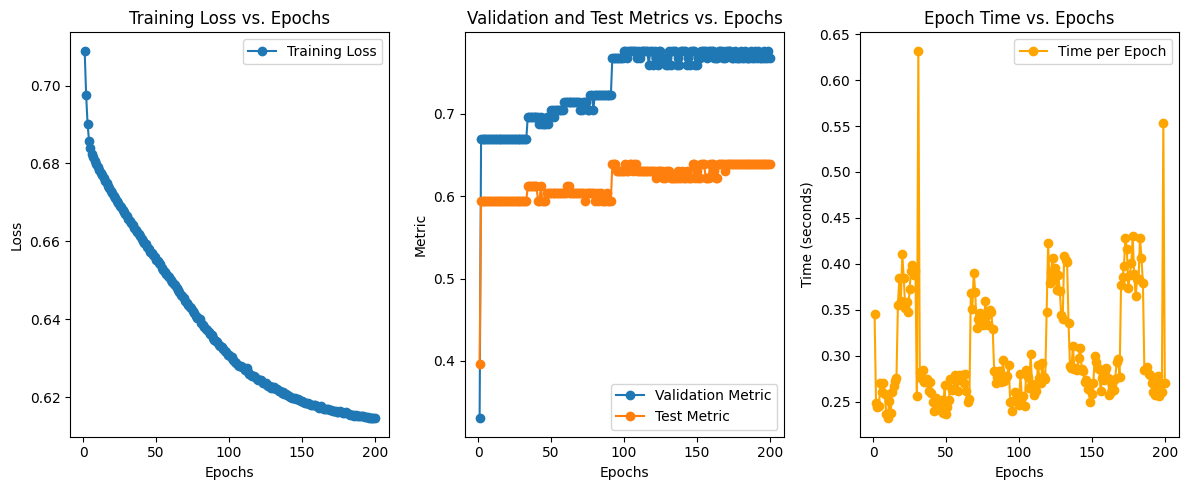

Best Validation Metric: 0.7767857142857143
Test Metric: 0.6306306306306306


In [22]:
# baseline GCNConv comparison
def conv_TUD(dataset_name):
  import numpy as np
  import os.path as osp
  import time
  from argparse import Namespace

  import torch
  import torch.nn.functional as F
  from torch.nn import Linear
  from tqdm import tqdm

  from torch_geometric.datasets import TUDataset
  from torch_geometric.nn import GCNConv, GraphMultisetTransformer
  from torch_geometric.datasets import MoleculeNet
  from torch_geometric.nn import global_mean_pool
  import torch_geometric
  from torch.utils.data import Dataset, DataLoader, random_split
  from torch_geometric.nn import global_mean_pool
  from torch.autograd import Variable

  path = '\tmp\tud'
  dataset = TUDataset(path, dataset_name).shuffle()

  num_classes = dataset.num_classes
  num_features = dataset.num_features
  hidden_channels = 32
  task_type='classification'
  # print(num_classes)

  def collate(data_list):
    batch = torch_geometric.data.Batch.from_data_list(data_list)
    return batch

  total_size = len(dataset)
  train_size = int(0.8 * total_size)
  test_size = (total_size - train_size) // 2
  val_size = total_size - train_size - test_size

  # Use random_split to split the dataset into train, test, and validation sets
  train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

  train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate)
  val_loader = DataLoader(val_dataset, batch_size=128, collate_fn=collate)
  test_loader = DataLoader(test_dataset, batch_size=128, collate_fn=collate)

  class NN(torch.nn.Module):
      def __init__(self):
          super().__init__()

          self.conv1 = GCNConv(in_channels=num_features, out_channels=hidden_channels, normalize=True)
          self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=num_classes, normalize=True)
          self.relu = torch.nn.ReLU()

          self.lin1 = Linear(32, 16)
          self.lin2 = Linear(16, num_classes)

      def forward(self, x0, edge_index, batch):
          x = self.conv1(x0, edge_index)
          x = self.relu(x)
          x = self.conv2(x, edge_index)
          # global mean pool instead of GMT, along with other adjustments
          output = global_mean_pool(x, batch)
          # output = output.detach().clone().requires_grad_(True)
          # x = self.lin1(x)
          # output = self.lin2(x)

          return output


  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = NN().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

  def train(loader):
      model.train()

      total_loss = 0

      epoch_iter = tqdm(loader, ncols=130)
      for step, batch in enumerate(epoch_iter):
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch.x, batch.edge_index, batch.batch)
          is_labeled = ~torch.isnan(batch.y) # Mask NaNs
          loss = F.cross_entropy(out[is_labeled], batch.y[is_labeled])
          loss.backward()
          # prevent exploding gradients if needed, uncomment
          # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          total_loss += batch.num_graphs * float(loss)
          optimizer.step()
      return total_loss / len(train_dataset)


  @torch.no_grad()
  def test(loader):

      model.eval()

      total_same = 0
      epoch_iter = tqdm(loader, ncols=130)
      for step, batch in enumerate(epoch_iter):
          batch = batch.to(device)
          out = model(batch.x, batch.edge_index, batch.batch)
          total_same += int((out.argmax(dim=-1) == batch.y).sum())
      return total_same / len(loader.dataset)


  times = []
  training_losses = []
  validation_metrics = []
  test_metrics = []
  for epoch in range(1, 201):
      start = time.time()
      train_loss = train(train_loader)
      val_acc = test(val_loader)
      test_acc = test(test_loader)
      training_losses.append(train_loss)
      validation_metrics.append(val_acc)
      test_metrics.append(test_acc)
      print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, '
            f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
      times.append(time.time() - start)
  print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")
  plot_training_metrics(training_losses, validation_metrics, test_metrics, times)
  print(f'Best Validation Metric: {max(validation_metrics)}')
  print(f'Test Metric: {test_metrics[np.argmax(validation_metrics)]}')

conv_TUD('DD')
conv_TUD('PROTEINS')